### DrugMechDB: A Comprehensive Curated Database of  Drug Mechanisms

Notebook to recreate figures of DrugMechDB manuscript

In [1]:
#import libraries 
import pandas as pd
import networkx as nx
import re
import yaml
from itertools import chain
from pathlib import Path
from operator import itemgetter
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from data_tools.data_tools.files._retrieval import download
from data_tools.data_tools.plotting import count_plot_h, venn2_pretty, venn3_pretty
from data_tools.data_tools.files._analysis import *

from pySankey.sankey import sankey
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Make the output folders
this_name = '1_basic_dmdb_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path('../0_data/external').resolve()
data_dir.mkdir(parents=True, exist_ok=True)

In [3]:
DMDB_URL = 'https://raw.githubusercontent.com/SuLab/DrugMechDB/main/indication_paths.yaml'
download(DMDB_URL, data_dir.joinpath('indication_paths.yaml'), redownload=False)

File indication_paths.yaml exits. Skipping...


In [4]:
with open(data_dir.joinpath('indication_paths.yaml'), 'r') as fh:
        ind = yaml.safe_load(fh)

In [5]:
all_metapath_nodes = get_metapath_node(ind)
all_metapath_edges = get_metapath_edges(ind)

In [6]:
basic_stats = defaultdict(list)
all_metaedges = []
all_parings = []
all_targets = []
unique_metaedges = []
first_edge_type = []
all_nodes = []

id_to_name = {}
id_to_label = {}

for i, p in enumerate(ind):
    _id = (p["graph"]["_id"])
    drug_id, dis_id = path_to_tup(p)
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    basic_stats['idx'].append(i) #index
    basic_stats['id'].append(p['graph']['_id']) #DrugMechDB id
    basic_stats['drug'].append(drug_id) #Drug id
    basic_stats['disease'].append(dis_id)#Disease id
    basic_stats['nodes'].append((G.nodes)) #nodes in metapath
    basic_stats['n_nodes'].append(len(G.nodes)) # number of nodes in metapath
    basic_stats['n_edges'].append(len(G.edges)) #number of edges in metapath
    basic_stats['n_paths'].append(len(all_metapath_nodes[_id])) #number of paths
    basic_stats['metapath'].append(all_metapath_nodes[_id])
    basic_stats['metapath_with_edges'].append(all_metapath_edges[_id])

    
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
    
    all_metaedges += this_metaedges
    unique_metaedges += list(set(this_metaedges))
    
    all_parings += [G.edges[e]['mn_pair'] for e in G.edges]
    all_targets += get_targets(G)
    first_edge_type += get_target_metaedges(G)
    all_nodes += list(G.nodes)
    
    id_to_label = {**id_to_label, **get_id_to_type(G)}
    id_to_name = {**id_to_name, **get_id_to_name(G)}
    
basic_stats = pd.DataFrame(basic_stats)

In [7]:
basic_stats.head()

,idx,id,drug,disease,nodes,n_nodes,n_edges,n_paths,metapath,metapath_with_edges
0,0,DB00619_MESH_D015464_1,DB:DB00619,MESH:D015464,"(MESH:D000068877, UniProt:P00519, MESH:D015464)",3,2,1,[Drug - Protein - Disease],[Drug - decreases activity of - Protein - caus...
1,1,DB00619_MESH_D034721_1,DB:DB00619,MESH:D034721,"(MESH:D000068877, UniProt:P10721, UniProt:P162...",5,5,1,[Drug - Protein - BiologicalProcess - Disease],[Drug - decreases activity of - Protein - posi...
2,2,DB00316_MESH_D010146_1,DB:DB00316,MESH:D010146,"(MESH:D000082, UniProt:P23219, UniProt:P35354,...",7,8,1,[Drug - Protein - BiologicalProcess - Chemical...,[Drug - decreases activity of - Protein - posi...
3,3,DB00316_MESH_D005334_1,DB:DB00316,MESH:D005334,"(MESH:D000082, REACT:R-HSA-2162123, UBERON:000...",5,4,1,[Drug - Pathway - GrossAnatomicalStructure - B...,[Drug - negatively regulates - Pathway - occur...
4,4,DB00945_MESH_D010146_1,DB:DB00945,MESH:D010146,"(MESH:D001241, UniProt:P23219, UniProt:P35354,...",7,7,1,[Drug - Protein - BiologicalProcess - Disease],[Drug - decreases activity of - Protein - posi...


Graph overview

In [8]:
#Count number of unique nodes
count_nodes_unique = set()
count_nodes = []
for indication in basic_stats["id"]: 
    nodes = list(basic_stats[basic_stats["id"] == indication]['nodes'].iloc[0])
    
    for n in nodes: 
        count_nodes_unique.add(n)
        count_nodes.append(n)

In [13]:
print("Number of nodes: ", len(count_nodes))
print("Number of unique nodes: ", len(count_nodes_unique))

Number of nodes:  32588
Number of unique nodes:  5125


In [10]:
print("Total edges: " , sum(basic_stats['n_edges'].to_list()) )

Total edges:  32249


In [11]:
print("Number of paths: " + str(sum(basic_stats['n_paths'])))

Number of paths: 5566


In [12]:
print("Number of unique drugs: " + str(len(set(basic_stats['drug']))))
print("Number of unique diseases: " + str(len(set(basic_stats['disease']))))
print("Number of unique drug-disease combinations: " + str(len(basic_stats.groupby(['drug','disease']).size())))


Number of unique drugs: 1580
Number of unique diseases: 744
Number of unique drug-disease combinations: 4583


## Figure 2: DrugMechDB concept types

A) Top encountered node types

In [14]:
node_counts = pd.Series(all_nodes, name='id')
node_counts = node_counts.to_frame().reset_index()
node_counts['label'] = node_counts['id'].map(id_to_label)

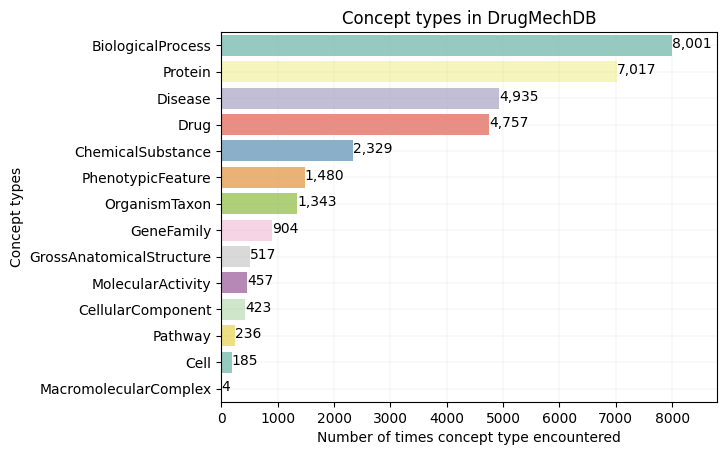

In [15]:
import matplotlib.pyplot as plt

plt.figure( dpi=100)
count_plot_h(node_counts['label'].value_counts())
plt.xlim(0,8800)
plt.grid(linewidth=0.1)
plt.title('Concept types in DrugMechDB')
plt.xlabel('Number of times concept type encountered')
plt.ylabel('Concept types')

#plt.savefig('Concept types in DrugMechDB.pdf')

#Change font style
font = {'family' : 'sans'}
plt.rc('font', **font)

In [16]:
#Calcualte % of most common label 
total_label = len((node_counts["label"]))#Average of nodes per indication 
sum(list(basic_stats['n_nodes']))/len((basic_stats['n_nodes']))
biological_label = len(node_counts[node_counts["label"]=="BiologicalProcess"])
(biological_label*100)/total_label

24.551982324782127

In [18]:
#Calcualte % of second most common label 
total_label = len((node_counts["label"]))#Average of nodes per indication 
sum(list(basic_stats['n_nodes']))/len((basic_stats['n_nodes']))
biological_label = len(node_counts[node_counts["label"]=="Protein"])
(biological_label*100)/total_label

21.532465938382227

B) Distribution of nodes per indication

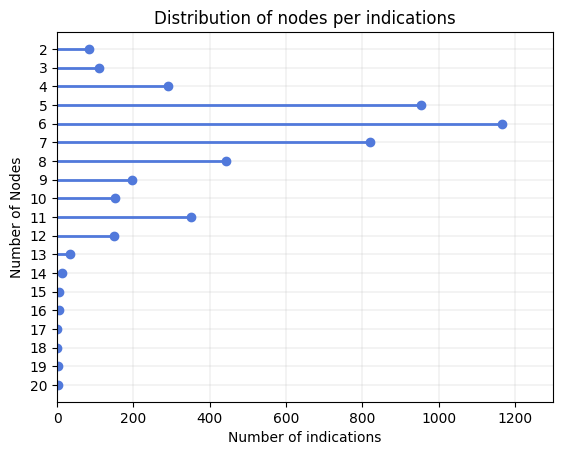

In [20]:
plt.figure( dpi=100)
(markers, stemlines, baseline) =  plt.stem([str(i) for i in range(2,21)],
         heads, 
         basefmt = " ",
        orientation = "horizontal", )

plt.setp(stemlines, linestyle="-", color= '#5179DB', linewidth= 2 )
plt.setp(markers,  color='#5179DB')
plt.xlim([0,1300])

plt.grid(linewidth=0.2)
plt.gca().invert_yaxis()
plt.title('Distribution of nodes per indications')
plt.ylabel('Number of Nodes')
plt.xlabel('Number of indications');

#plt.savefig('Distribution of nodes per indications.pdf')

C) Node popularity 

In [21]:
metanode_node = defaultdict(list)
for i in range(len(ind)): 
    for id_ in ind[i]["nodes"]:
        
        metanode_node[id_["label"]].append(id_["name"])

In [23]:
#Join concept 
list_concept = []
for i in  metanode_node["BiologicalProcess"]:
    split_concept = i.split(" ")
    join_concept = "_".join(i for i in split_concept)
    list_concept.append(join_concept)

In [24]:
text_bp = " ".join(cat for cat in list_concept)

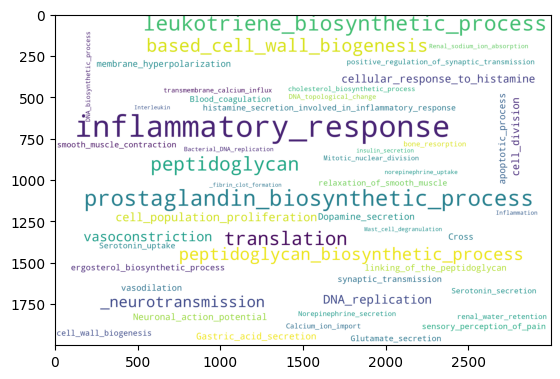

In [25]:
plt.figure( dpi=100)
word_cloud = WordCloud(
width = 3000,
height= 2000, 
random_state= 1,
background_color= "white",
max_words=50,
collocations= False,
stopwords= STOPWORDS).generate(text_bp)
plt.imshow(word_cloud)


wordcloud_svg = word_cloud.to_svg(embed_font=True)
# f = open("BP_WC.svg","w+")
# f.write(wordcloud_svg )
# f.close()

In [26]:
#Join concept 
list_concept = []
for i in  metanode_node["Protein"]:
    split_concept = i.split(" ")
    join_concept = "_".join(i for i in split_concept)
    list_concept.append(join_concept)

In [27]:
text_protein = " ".join(cat for cat in list_concept)

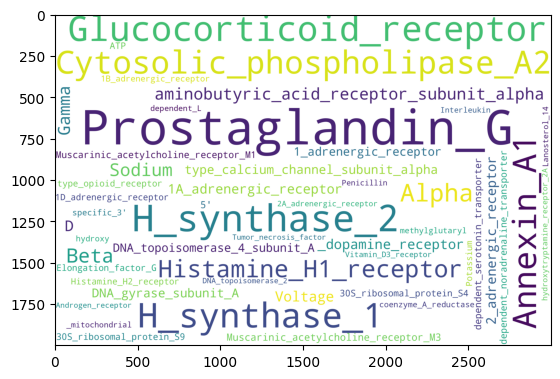

In [28]:
plt.figure( dpi=100)
word_cloud = WordCloud(
width = 3000,
height= 2000, 
random_state= 1,
background_color= "white",
max_words=50,
collocations= False,
stopwords= STOPWORDS).generate(text_protein)
plt.imshow(word_cloud)


wordcloud_svg = word_cloud.to_svg(embed_font=True)
# f = open("Protein.svg","w+")
# f.write(wordcloud_svg )
# f.close()

In [29]:
#Join concept 
list_concept = []
for i in  metanode_node["Disease"]:
    split_concept = i.split(" ")
    join_concept = "_".join(i for i in split_concept)
    list_concept.append(join_concept)

In [30]:
text_dis = " ".join(cat for cat in list_concept)

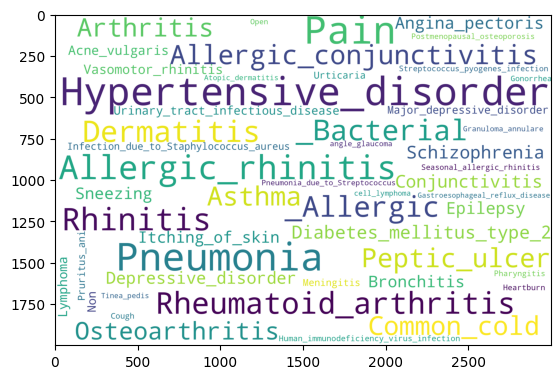

In [31]:
plt.figure( dpi=100)
word_cloud = WordCloud(
width = 3000,
height= 2000, 
random_state= 1,
background_color= "white",
max_words=50,
collocations= False,
stopwords= STOPWORDS).generate(text_dis)
plt.imshow(word_cloud)


wordcloud_svg = word_cloud.to_svg(embed_font=True)
# f = open("Disease_WC.svg","w+")
# f.write(wordcloud_svg )
# f.close()

In [32]:
#Join concept 
list_concept = []
for i in  metanode_node["Drug"]:
    split_concept = i.split(" ")
    join_concept = "_".join(i for i in split_concept)
    list_concept.append(join_concept)

In [33]:
text_drug = " ".join(cat for cat in list_concept)

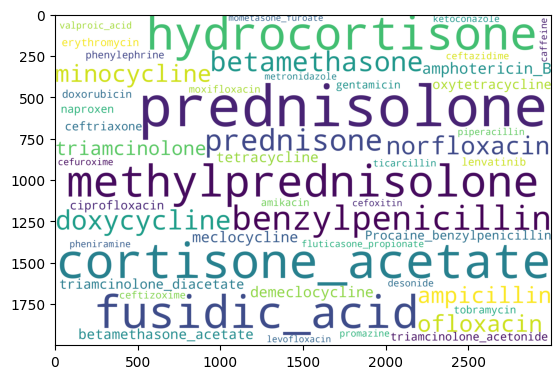

In [34]:
plt.figure( dpi=100)
word_cloud = WordCloud(
width = 3000,
height= 2000, 
random_state= 1,
background_color= "white",
max_words=50,
collocations= False,
stopwords= STOPWORDS).generate(text_drug)
plt.imshow(word_cloud)


wordcloud_svg = word_cloud.to_svg(embed_font=True)
# f = open("Drug_WC.svg","w+")
# f.write(wordcloud_svg )
# f.close()

## Figure 3: DrugMechDB edge types

A) Concept type associations

In [35]:
pairs  = set()

for val in all_parings:
    val = val.split(" - ")
    pairs.add(val[0])

In [36]:
#all combination of concept type pairs DMDB 
print("Total combination of concept type pairs: ", len(set(all_parings)))

Total combination of concept type pairs:  129


<Figure size 640x480 with 0 Axes>

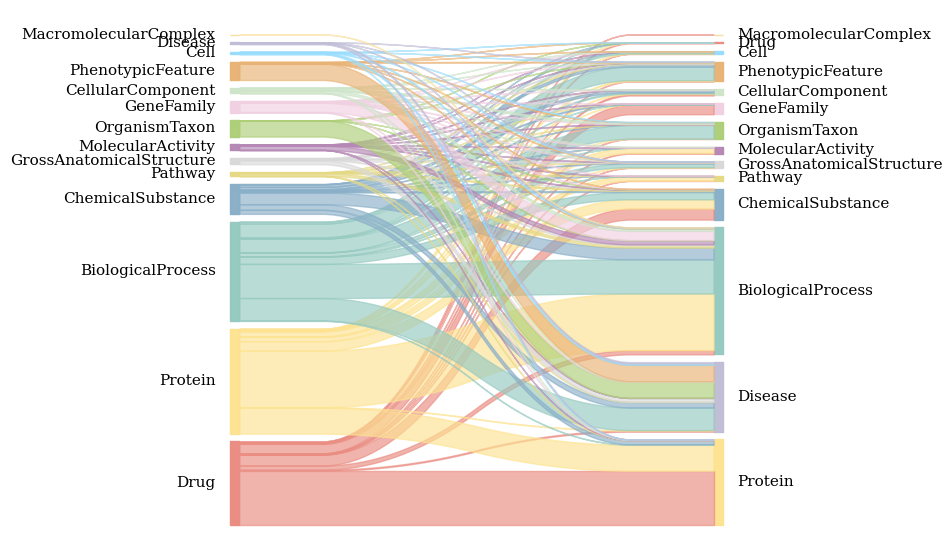

In [40]:
#Sankey diagram 
colorDict = {'BiologicalProcess': "#96CAC1",
 'Cell': "#99DDFE" ,
 'CellularComponent': "#CEE5CA",
 'ChemicalSubstance': "#8AAFC8",
 'Disease': "#C0BED6",
 'Drug': "#EA8D82",
 'GeneFamily': "#F0D0E1",
 'GrossAnatomicalStructure': "#D9D9D9",
 'MacromolecularComplex': "#F8DF9D",
 'MolecularActivity': "#B588B5",
 'OrganismTaxon': "#AECF78",
 'Pathway': "#E5D986",
 'PhenotypicFeature': "#E9B375",
 'Protein': "#FDE391"}

plt.figure(dpi=100)
source =[]
target =[]

for val in all_parings:
    val = val.split(" - ")
    source.append(val[0])
    target.append(val[1])
sankey(source,
       target, 
       aspect=15, 
       fontsize=11, 
      colorDict=colorDict)
# Get current figure
fig = plt.gcf()


# Set size in inches
fig.set_size_inches(7, 7)

# Set the color of the background to white
fig.set_facecolor("w")

# Save the figure
#fig.savefig("DMDB_relations_sankey.pdf", bbox_inches="tight", dpi=1000)

In [41]:
#Count % of most frequent metapair
total_pairs = (all_parings)
print("Total concept type pairs: ", len(total_pairs))


most_frequent_pair = len([i for i in all_parings if i == 'Protein - BiologicalProcess'])
print("Most frequent pair: ('Protein - BiologicalProcess') ", most_frequent_pair)

print("% most frequent pair ('Protein - BiologicalProcess'): ", (most_frequent_pair*100)/len(total_pairs))

Total concept type pairs:  32249
Most frequent pair: ('Protein - BiologicalProcess')  4695
% most frequent pair ('Protein - BiologicalProcess'):  14.558590964060901


B) Most common meta-edges

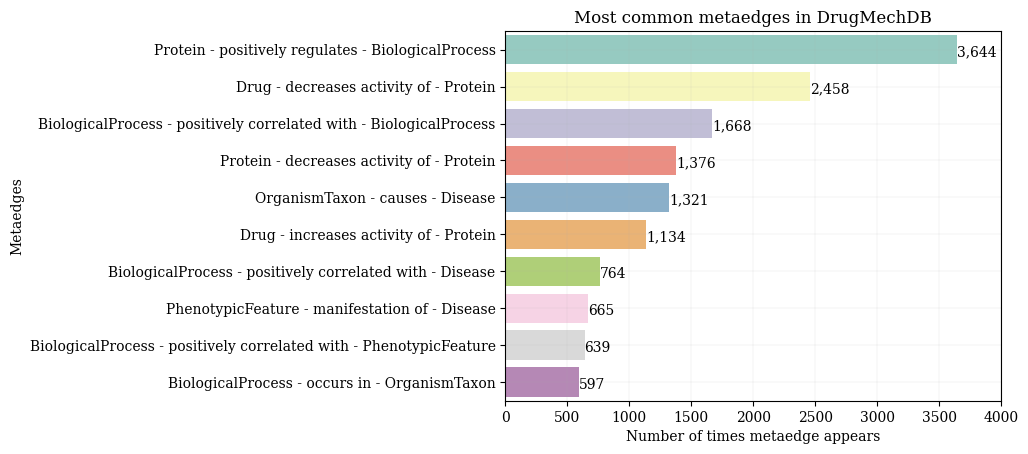

In [42]:
plt.figure( dpi=100)
me_counts = pd.Series(all_metaedges).value_counts()
count_plot_h(me_counts.head(10))
font = {'family' : 'sans'}
plt.rc('font', **font)

plt.grid(linewidth=0.1)
plt.ylabel('Metaedges')
plt.xlim(0,4000)

font = {'family' : 'sans'}
plt.rc('font', **font)

plt.title('Most common metaedges in DrugMechDB')
plt.xlabel('Number of times metaedge appears');
#plt.savefig('Most common metaedges in DrugMechDB.pdf')

In [43]:
#Meta-edges (Source-relation-Target)
print("Number of unique meta-edges: ", len(set(all_metaedges)))

Number of unique meta-edges:  725


In [47]:
#Calculate percentage of most common metaedge 
total_metaedges = (all_metaedges)
most_common_me = len([i for i in total_metaedges if i =='Protein - positively regulates - BiologicalProcess'])

print("Most common meta-edge('Protein - positively regulates - BiologicalProcess'): ", 
      most_common_me, 
      f"({(most_common_me*100)/len(all_metaedges)}%)")

Most common meta-edge('Protein - positively regulates - BiologicalProcess'):  3644 (11.299575180625755%)
11.299575180625755


C) Distribution of edges per indication 

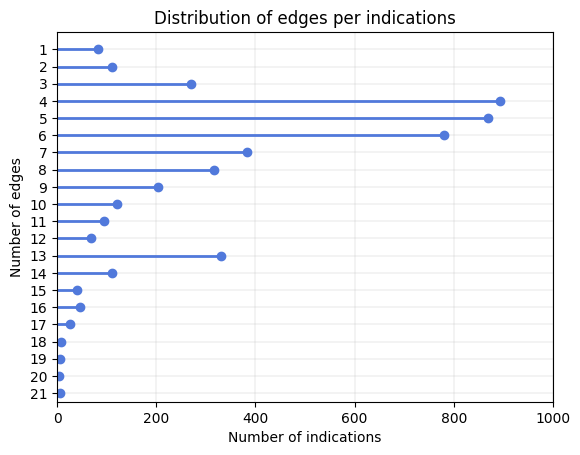

In [48]:
heads, locs = np.histogram(basic_stats['n_edges'], bins= 31)
plt.figure( dpi=100)
(markers, stemlines, baseline) =  plt.stem([str(i) for i in range(1,32)],
         heads, 
         basefmt = " ",
        orientation = "horizontal", )

plt.setp(stemlines, linestyle="-", color= '#5179DB', linewidth= 2 )
plt.setp(markers,  color='#5179DB')
plt.xlim([0,1000])
plt.ylim([-1,20.5])

plt.grid(linewidth=0.2)
plt.gca().invert_yaxis()
plt.title('Distribution of edges per indications')
plt.ylabel('Number of edges')
plt.xlabel('Number of indications');

# plt.savefig('Distribution of edges per indication.pdf')

## Figure 4: DrugMechDB mechanistic paths

A) Most common mechanistic paths (excluding edges)

In [54]:
metapaths_df = pd.DataFrame( columns= ["DMDB_ID", "Metapath"])

for id_ in all_metapath_nodes:
    for p in all_metapath_nodes[id_]:
        metapaths_df = metapaths_df.append({"DMDB_ID": id_, 
                            "Metapath": p}, ignore_index= True)

print("Nmber of unique mechanistic paths (excluding edges): ", len(set(metapaths_df["Metapath"].to_list())))

Nmber of unique mechanistic paths (excluding edges):  297


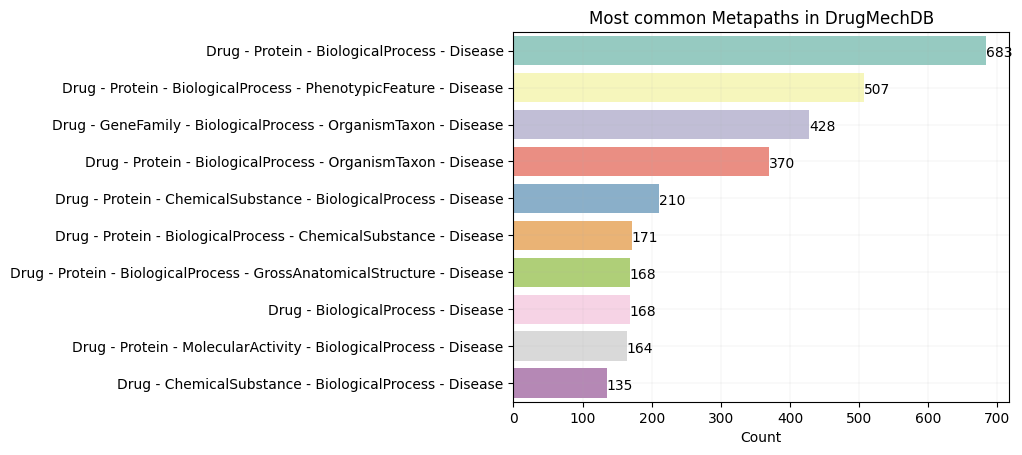

In [50]:
plt.figure( dpi=100)
me_counts = pd.Series(metapaths_df["Metapath"]).value_counts()
count_plot_h(me_counts.head(10))

plt.grid(linewidth=0.1)
plt.ylabel('');
plt.title('Most common Metapaths in DrugMechDB')
plt.xlabel('Count');

# plt.savefig('Most common Metapaths in DrugMechDB.pdf')

In [58]:
#Number of metapaths
mp_nodes = []
for id_ in all_metapath_nodes:
    for p in all_metapath_nodes[id_]:
        mp_nodes.append(p)


total_mp_nodes = len(((mp_nodes)))
most_common_mp = len([i for i in mp_nodes if i == "Drug - Protein - BiologicalProcess - Disease"])


print("Most common meta-path(Drug - Protein - BiologicalProcess - Disease): ", most_common_mp, 
      f"({(most_common_mp*100)/total_mp_nodes}%)")

Most common meta-path(Drug - Protein - BiologicalProcess - Disease):  683 (12.270930650377291%)


B) Most common mechanistic paths (including edges)


In [59]:
mp_edges = []
for id_ in all_metapath_edges:
    for p in all_metapath_edges[id_]:
        mp_edges.append(p)

print("Number of mechanistic paths (including edges): ",(len(set(mp_edges))))

Number of mechanistic paths (including edges):  1457


In [60]:
metapaths_edge_df = pd.DataFrame( columns= ["DMDB_ID", "Metapath_edge"])

for id_ in all_metapath_edges:
    for p in all_metapath_edges[id_]:
        metapaths_edge_df = metapaths_edge_df.append({"DMDB_ID": id_, 
                            "Metapath_edge": p}, ignore_index= True)

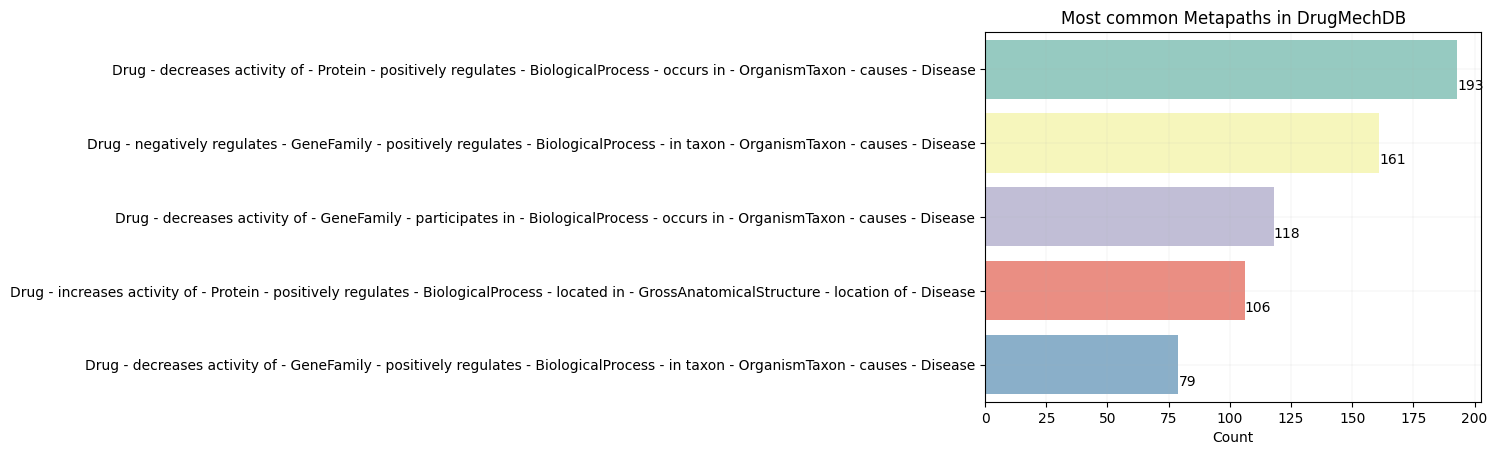

In [61]:
plt.figure( dpi=100)
me_counts = pd.Series(metapaths_edge_df["Metapath_edge"]).value_counts()
count_plot_h(me_counts.head(5))

plt.grid(linewidth=0.1)
plt.ylabel('');
plt.title('Most common Metapaths in DrugMechDB')
plt.xlabel('Count');

# plt.savefig('Most common Metapaths in DrugMechDB_B.pdf')

In [64]:
#number of meta_paths (with edges)
total_mp_edges = len((mp_edges))
most_common_mp_edge = len([i for i in mp_edges if i == "Drug - decreases activity of - Protein - positively regulates - BiologicalProcess - occurs in - OrganismTaxon - causes - Disease"])

print("Most common meta-path(Drug - decreases activity of - Protein - positively regulates - BiologicalProcess - occurs in - OrganismTaxon - causes - Disease): ", most_common_mp_edge, 
      f"({(most_common_mp_edge*100)/total_mp_edges}%)")



Most common meta-path(Drug - decreases activity of - Protein - positively regulates - BiologicalProcess - occurs in - OrganismTaxon - causes - Disease):  193 (3.467481135465325%)


C) Distribution of paths per indication

Text(0.5, 0, 'Number of indications')

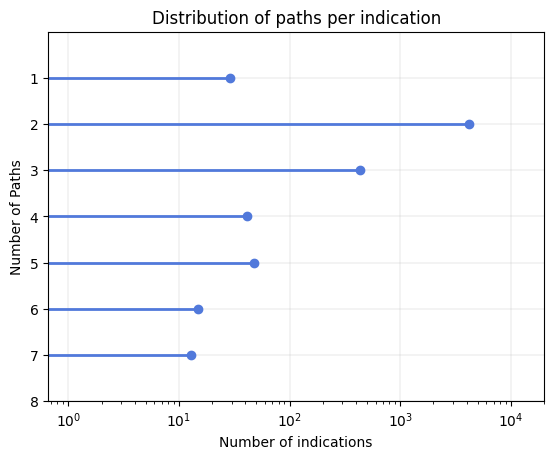

In [65]:
heads, locs = np.histogram(basic_stats['n_paths'], bins= 21)
plt.figure( dpi=100)
(markers, stemlines, baseline) =  plt.stem([str(i) for i in range(1,22)],
         heads, 
         basefmt = " ",
        orientation = "horizontal", )

plt.setp(stemlines, linestyle="-", color= '#5179DB', linewidth= 2 )
plt.setp(markers,  color='#5179DB')
plt.xscale("log")

plt.ylim([-1,7])
plt.xlim([0,20000])

plt.grid(linewidth=0.2)
plt.gca().invert_yaxis()
plt.title('Distribution of paths per indication')
plt.ylabel('Number of Paths')
plt.xlabel('Number of indications')


#plt.savefig('Distribution of paths per indication.pdf')

### Table 1

In [66]:
#outgoing edges

node_me = defaultdict(list)
node_me_unique = defaultdict(set)

for mp in all_metaedges:
    mp = mp.split(" - ")
    node_me[mp[0]].append(mp[1])
    node_me_unique[mp[0]].add(mp[1])

In [67]:
#Edge count by concept type
sum_node_me = 0
for k,v in node_me.items():
    sum_node_me += len(v)
    print(k, len(v))

print(sum_node_me)

Drug 6886
Protein 8704
BiologicalProcess 8235
ChemicalSubstance 2474
Pathway 348
GrossAnatomicalStructure 534
MolecularActivity 474
OrganismTaxon 1343
GeneFamily 958
CellularComponent 456
PhenotypicFeature 1499
Cell 186
Disease 147
MacromolecularComplex 5
32249


In [68]:
#Unique Edge-types by concept type
sum_node_me = 0
for k,v in node_me_unique.items():
    sum_node_me += len(v)
    print(k, len(v))

print(sum_node_me)

Drug 38
Protein 33
BiologicalProcess 38
ChemicalSubstance 35
Pathway 20
GrossAnatomicalStructure 24
MolecularActivity 21
OrganismTaxon 5
GeneFamily 21
CellularComponent 15
PhenotypicFeature 17
Cell 19
Disease 12
MacromolecularComplex 1
299
